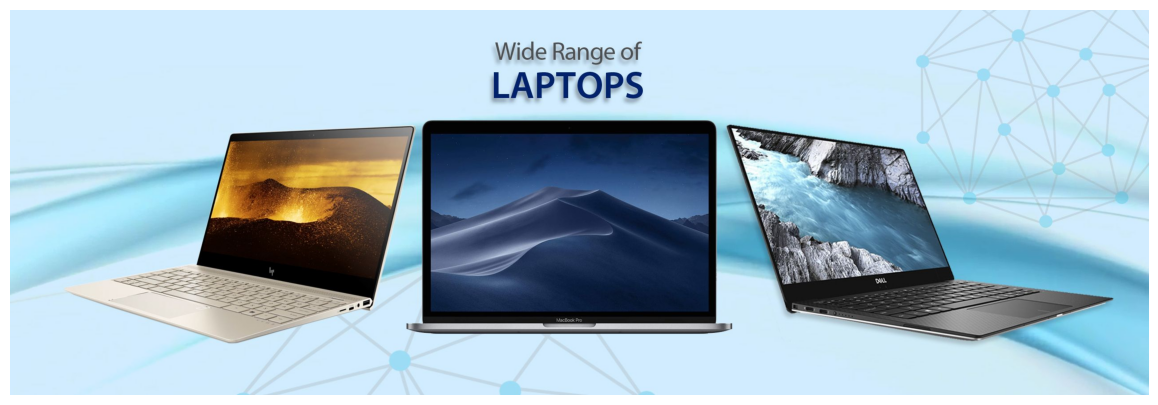

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('C:/Users/ASUS/Documents/Data Analis Project/Python Scripts/Dataset/Laptop.jpg')
plt.figure(figsize=(16,5))
plt.imshow(img, extent=[0, img.shape[1], img.shape[0], 0])
plt.axis('off')
plt.show()

image:Muhammad Adeel

# Laptops Price Predictoin using XGBoost Regressor

by : Elza Fr

In today's dynamic tech market, predicting laptop prices accurately is a valuable skill. We'll explore data science and machine learning to develop a model that estimates laptop prices based on features like brand, specs, and more. 

my goal is to empower consumers and businesses with data-driven insights, making informed decisions in the ever-changing laptop landscape. Join me on this journey as we unravel the secrets behind laptop pricing and harness the power of data science.

In [2]:
# Import Package Needed
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Datasets Description

Source : Kaggle.com

- Laptop : Laptop Name
- Status : Laptop condition status
- Brand : company's products
- Model : Product series with similar features, designs, or specifications
- CPU : Series of various architectures in CPU
- RAM : Amount of temporary storage for data and instructions that the CPU needs to access quickly during its operations
- Storage : Amount Size of components used to store and retain digital data
- Storage Type : Type of Storage Series based on factors such as performance needs, storage capacity, and intended use.
- GPU : Series of Electronics Circuit to accelerate a wide range of non-graphical applications.
- Screen : Diagonal size of screen display
- Touch : available screen touch or not
- Final Price : Final Price based on official Source like official website

In [3]:
# Import Dataset and Display Example of Data
df = pd.read_csv('Dataset/laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [4]:
# Info of General dataset to view null and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


# Data Adjusment

data adjustment is a crucial preparatory step in the data analysis process. It involves tasks like :
- standardization
- handling missing data
- drop specific column
- and more

These adjustments ensure that the data is in a suitable format for analysis, improving the quality and accuracy of the results.

In [5]:
# Conditioning column name
df.columns = [column.lower() for column in df.columns]
df.columns = [column.replace(" ","_") for column in df.columns]
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [6]:
# Conditioning Laptop name by extracting Name before the CPU specification
def extract_value(row):
    text = row['laptop']
    keyword = row['cpu']
    return text.split(keyword)[0].strip()

df['laptop'] = df.apply(extract_value,axis=1)
df['laptop'].sample(2)

499    MSI Prestige 16 A12UD-221XES
782          HP ProBook 635 Aero G7
Name: laptop, dtype: object

In [7]:
# Conditioning GPU classification by determining based on Type : on board (Internal) and External (seperated)
def adjustment_gpu(row):
    if pd.isnull(row['gpu']):
        return "Internal"
    else:
        return "External"

df['gpu_adj'] = df.apply(adjustment_gpu,axis=1)
df['gpu_adj'].unique()

array(['Internal', 'External'], dtype=object)

In [8]:
# Changing Data type into categorical
object_column = ['ram','storage','screen']

for i in object_column:
    df[i] = df[i].astype(object)

In [9]:
# See null value (Storgae Type) based on categorical column (CPU)
df['cpu'][df['storage_type'].isnull()].unique()

array(['Intel Celeron', 'Intel Core i5', 'Intel Core i7', 'AMD Radeon 5',
       'Intel Core i3', 'AMD Athlon', 'Intel Core M3', 'AMD Ryzen 7',
       'Intel Pentium', 'Qualcomm Snapdragon 8'], dtype=object)

In [10]:
# Fill the null value for storage type based on conditioning CPU
low_storage = ['Intel Celeron','AMD Athlon','Intel Pentium','Qualcomm Snapdragon 8']

def storage_fillna(row):
    if pd.isnull(row['storage_type']) and row['cpu'] in low_storage:
        return "eMMC"
    elif pd.isnull(row['storage_type']) and row['cpu'] not in low_storage:
        return "SSD"
    else:
        return row['storage_type']

In [11]:
# Determining new Categorical Column
df['storage_type'] = df.apply(storage_fillna, axis = 1)

# Fill the remain null column
df['screen'] = df['screen'].fillna(method = 'bfill')

# drop the unnecessary Column
df = df.drop('gpu',axis=1)

In [12]:
# See the Clean Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop        2160 non-null   object 
 1   status        2160 non-null   object 
 2   brand         2160 non-null   object 
 3   model         2160 non-null   object 
 4   cpu           2160 non-null   object 
 5   ram           2160 non-null   object 
 6   storage       2160 non-null   object 
 7   storage_type  2160 non-null   object 
 8   screen        2160 non-null   float64
 9   touch         2160 non-null   object 
 10  final_price   2160 non-null   float64
 11  gpu_adj       2160 non-null   object 
dtypes: float64(2), object(10)
memory usage: 202.6+ KB


# Data Visualization

In essence, data visualization is a versatile tool that enhances data understanding, supports decision-making, and facilitates effective communication of insights across a wide range of applications

Data Visualization is very important step to gathering more insight of the Data. The following Visual plot below have function like :
- presenting univariate data distribution
- visualizing categorical data
- see distribution of numerical data across different categories
- comparation function

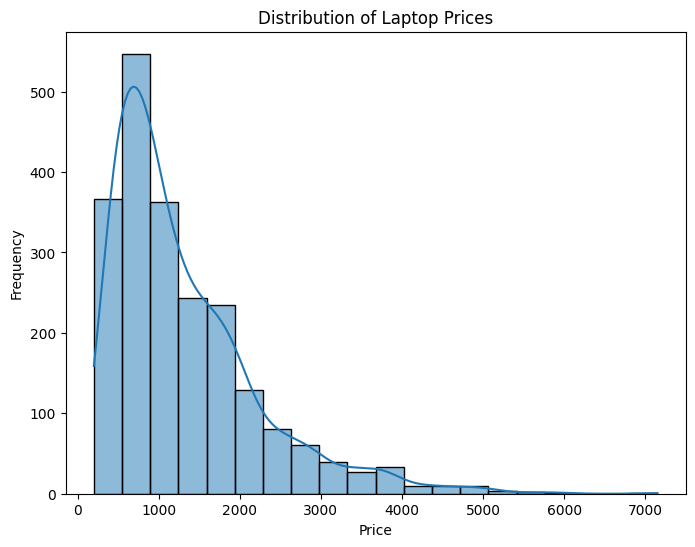

In [13]:
# See Final Price Distribution Data via Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['final_price'], bins=20, kde=True)
plt.title("Distribution of Laptop Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

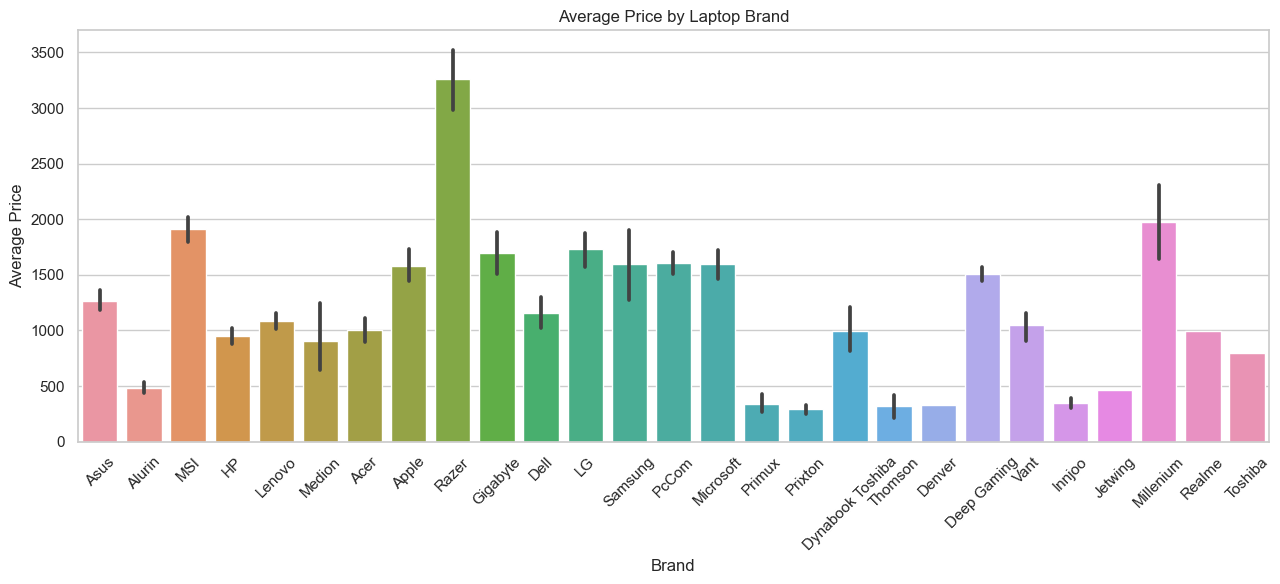

In [14]:
# Display Price per Brand using Barplot
sns.set(style="whitegrid")
plt.figure(figsize=(13, 6))
sns.barplot(x="brand", y="final_price", data=df)
plt.title("Average Price by Laptop Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

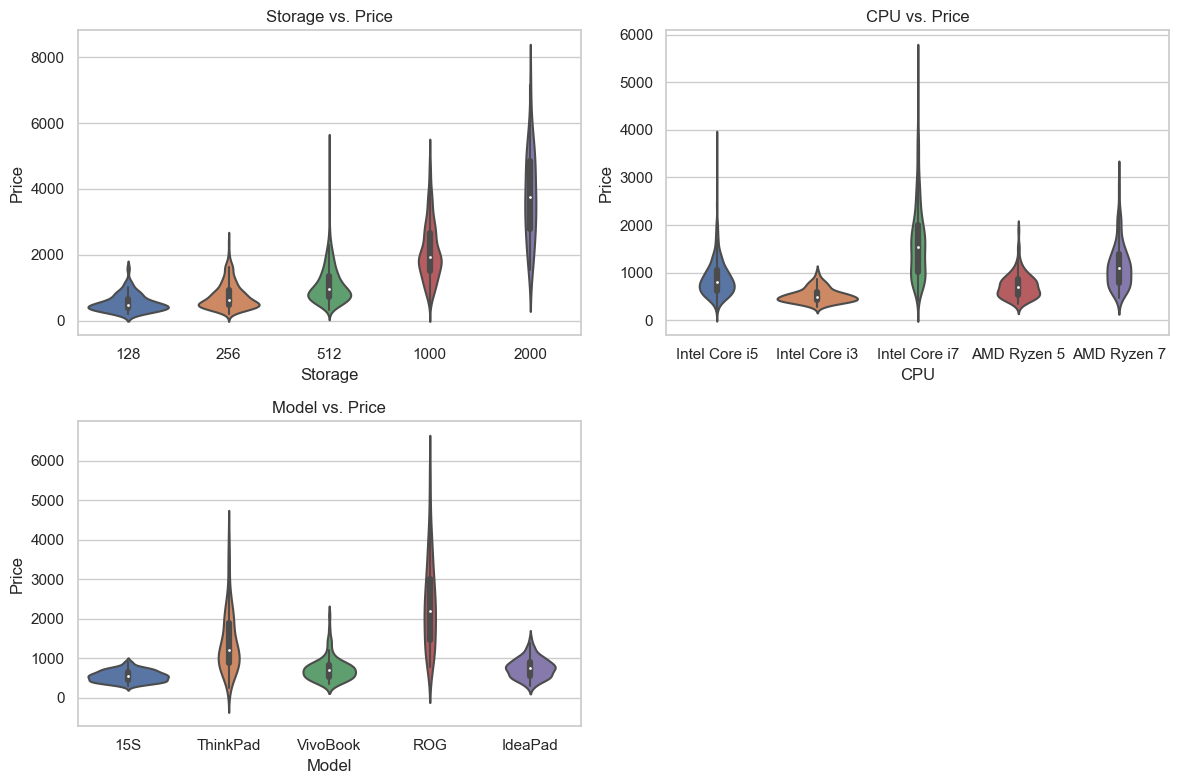

In [15]:
# Display final price Violinplot for Top 5 Storage, CPU, and Model as Categorical
top_5_storage = pd.DataFrame(df['storage'].value_counts().nlargest(5))
top_5_storage = df[df['storage'].isin(top_5_storage.index)]

top_5_cpu = pd.DataFrame(df['cpu'].value_counts().nlargest(5))
top_5_cpu = df[df['cpu'].isin(top_5_cpu.index)]

top_5_model = pd.DataFrame(df['model'].value_counts().nlargest(5))
top_5_model = df[df['model'].isin(top_5_model.index)]
#---------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.violinplot(data=top_5_storage, x='storage', y='final_price',ax=axes[0, 0], gridspec_kw={'height_ratios': [1, 2]})
axes[0, 0].set_title("Storage vs. Price")
axes[0, 0].set_xlabel('Storage')
axes[0, 0].set_ylabel('Price')

sns.violinplot(data=top_5_cpu, x='cpu', y='final_price',ax=axes[0, 1])
axes[0, 1].set_title("CPU vs. Price")
axes[0, 1].set_xlabel('CPU')
axes[0, 1].set_ylabel('Price')

sns.violinplot(data=top_5_model, x='model', y='final_price',ax=axes[1, 0])
axes[1, 0].set_title("Model vs. Price")
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Price')

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

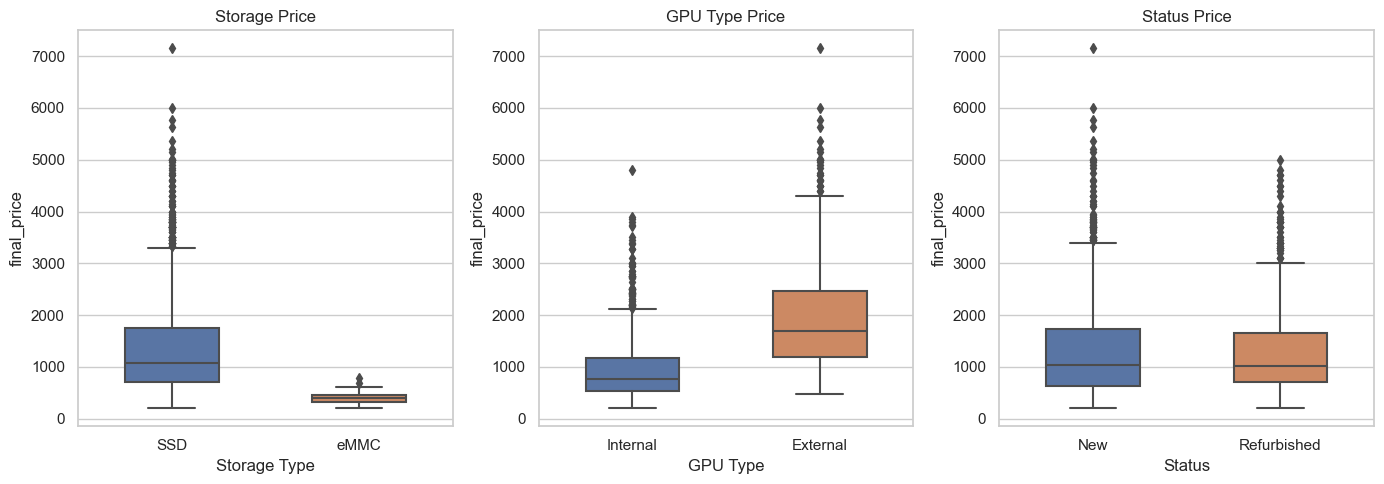

In [16]:
# Set Box Plot to see distribution final price for Storage, GPU Type, Status data
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(14,5))

sns.boxplot(x="storage_type", y="final_price", data=df, width=0.5, ax=axes[0])
axes[0].set_xlabel('Storage Type')
axes[0].set_title('Storage Price')

sns.boxplot(x="gpu_adj", y="final_price", data=df, width=0.5, ax=axes[1])
axes[1].set_xlabel('GPU Type')
axes[1].set_title('GPU Type Price')

sns.boxplot(x="status", y="final_price", data=df, width=0.5, ax=axes[2])
axes[2].set_xlabel('Status')
axes[2].set_title('Status Price')

plt.tight_layout()
plt.show()

# Data Preprocessing

Data preprocessing is a critical step in the data analysis and machine learning pipeline. It involves a series of actions and transformations applied to raw data to prepare it for analysis or modeling.

- in this procedure we gonna perform encoding to make categorical data into numeric format so it can fit with machine learning. So many machine learning and statistical algorithms are designed to work with numerical data. the column in Laptop Data like status, brand, model, etc is categorical object Data.

- Determining independet and Dependent variabel gonna shapes the research process, guides the selection of appropriate methods, and allows for the testing of hypotheses and the interpretation of results. for this, we determine the encoded column such a model, ram, storage, brand, etc as a independent Data as a main factor which affected the dependent Data (Final Price).

-  then we gonna split the Dataset into Test and Train. It allows us to assess a model's performance on unseen data, ensuring that it generalizes effectively. Proper random splitting and considerations for class balance and reproducibility are essential for robust model evaluation and development.

In [17]:
# Encoding by Create new categorical Data using LabelEncoding
le = LabelEncoder()

label_columns = ['status','brand','model','cpu','ram','storage','storage_type','screen','touch','gpu_adj']

for column in label_columns:
    df[column+'_label'] = le.fit_transform(df[column])

In [18]:
# Set Train and Test split for Independent and Dependent Variabel
x = df.iloc[:,12:22]
y = df['final_price']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3,random_state=0)

# Data Modelling

Modelling is a main dish for Data Science process. for this modelling i use the XGB Regressor as a Model, because Regression models are designed to predict continuous outcomes, and float data (Final Price) aligns with this requirement.

The XGBoost Regressor, is a popular machine learning algorithm used for regression tasks. It is an implementation of the gradient boosting algorithm and is widely used for various reasons:
- High Predictive Accuracy: XGBoost is known for its exceptional predictive accuracy. It consistently performs well in various regression problems and is a top choice in data science competitions.
- Handling Non-Linear Relationships: XGBoost is capable of capturing complex non-linear relationships between features and the target variable. It can model intricate patterns in the data, which can be challenging for simpler models like linear regression.
- Flexibility: XGBoost supports a wide range of objective functions and evaluation metrics, allowing you to tailor the model to your specific regression problem. It can be used for both single-output and multi-output regression tasks data.

In [19]:
# Determining Model Regressor machine learning using XGBoost
XGB = XGBRegressor(n_estimators=100, max_depth=3, random_state=0)
XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [20]:
# Set y_pred
y_pred = XGB.predict(x_test)

# Model Evaluation

Evaluation Section for this model to see how the Laptop Price modelling is doing in terms of making predictions and whether it meets your project's goals and requirements. there's many criteria for evaluation modelling performance, for example :
- Evaluation Metrics : Select appropriate evaluation metrics based on the type of problem are solving. For this XGBoost regression modelling, metrics like MSE, and R-squared are the best pick up as a metrics.
  
- Interpretability : Depending on the model type, it's crucial to interpret the model's predictions. Understand which features are influential, and if possible, interpret the model's decision-making process.
  
- Deployment : This model meets the desired performance criteria, so we can deploy it for real-world use. We try to input specific value to access the modelling result from datasets such as model, ram, storage, type, etc.n.

In [21]:
# Set the Evaluation Score using MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²) Score:", r2)

Mean Squared Error (MSE): 164649.66133639342
R-squared (R²) Score: 0.8048372842495214


In [22]:
# Display example Data value as a mini dictionary
print('Mini Dictionary\n')
for column in label_columns:
    if len(df[column].unique()) > 10:
        print(column+':')
        print(df[column].head(20).unique(),'\n')
    else:
        print(column+':')
        print(df[column].unique(),'\n')

Mini Dictionary

status:
['New' 'Refurbished'] 

brand:
['Asus' 'Alurin' 'MSI' 'HP' 'Lenovo' 'Medion'] 

model:
['ExpertBook' 'Go' 'Katana' '15S' 'Crosshair' 'ThinkPad' 'VivoBook'
 'Akoya' 'Victus' 'V15' 'Thin' 'ROG' 'IdeaPad'] 

cpu:
['Intel Core i5' 'Intel Celeron' 'Intel Core i3' 'Intel Core i7'
 'AMD Ryzen 5' 'AMD Ryzen 7' 'AMD Ryzen 3'] 

ram:
[8 16 32 12 4 64 128 6 40] 

storage:
[512 256 1000] 

storage_type:
['SSD' 'eMMC'] 

screen:
[15.6 17.3 14.  16.1] 

touch:
['No' 'Yes'] 

gpu_adj:
['Internal' 'External'] 



__Prediction__

We need to input Specific Value to Modelling Variable, so we can see how much prediction of Laptop Price depending on what specification is.

In [23]:
# Setting the Value Predictors to Predict Laptop Price
status = 'New'
brand = 'Asus'
model = 'VivoBook'
cpu = 'Intel Core i3'
ram = 8
storage = 512
storage_type = 'SSD'
screen = 16.1
touch = 'No'
gpu_adj = 'Internal'

In [24]:
# Transforming The Predictor Value to encoding to fit the Model
attributes = ['status', 'brand', 'model', 'cpu', 'ram', 'storage', 'storage_type', 'screen', 'touch', 'gpu_adj']
labels = {}

for i, attr in enumerate(attributes, start=1):
    label = df.loc[df[attr] == locals()[attr], f'{attr}_label'].iloc[0]
    locals()[f'x{i}'] = label
    labels[attr] = label

In [25]:
# Predict the Price Value based on Model that created
Criteria = f"Status: {status}\nBrand: {brand}\nModel: {model}\nCPU: {cpu}\nRAM: {ram} GB\nStorage: {storage} GB {storage_type}\nScreen: {screen} inches\nTouch: {touch}\nGPU: {gpu_adj}"
print(Criteria,'\n\nLaptop Price Prediction :',XGB.predict([[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]]),'USD$')

Status: New
Brand: Asus
Model: VivoBook
CPU: Intel Core i3
RAM: 8 GB
Storage: 512 GB SSD
Screen: 16.1 inches
Touch: No
GPU: Internal 

Laptop Price Prediction : [469.51868] USD$


-------------------------------------------------------------------------------------------------------------------------------------------------------

Summary : 

As the laptop market continues to evolve, leveraging the capabilities of XGBoost allows us to stay ahead, adapt to changing trends, and make informed decisions about laptop pricing strategies. In this data-driven age, XGBoost modeling serves as a valuable tool in unlocking insights and maximizing value in the laptop industry.

__Thanks for Attention, hope this analysis get u some great insight__